### 620 Project 3
#### Further analysis of NASA ADS publications: two-mode network analysis
Daina Bouquin
   
Below is an analysis of affiliations between authors and journals in the 2-mode [NASA Astrophysics Data Systems](https://ui.adsabs.harvard.edu/) dataset. This project builds on work performed in Project 2. The primary objective of this project is to use clustering techniques (e.g. the island method) to try to find small sub-networks of important authors that are frequently collaborating together. In doing so we can also see which journals stand out as focal points for these types of collaborations.

In [50]:
import networkx as nx
import os
import ads as ads 
import matplotlib.pyplot as plt
import pandas as pd
from networkx.algorithms import bipartite as bi

In [51]:
os.environ["ADS_DEV_KEY"] = "kNUoTurJ5TXV9hsw9KQN1k8wH4U0D7Oy0CJoOvyw"

In [52]:
ads.config.token = 'ADS_DEV_KEY' 

In [59]:
#Search for papers (50 most cited) on stars (very general search)
papers1 = list(ads.SearchQuery(q= "stars", sort="citation_count", max_pages=1 ))

In [60]:
# find author names
a = []
for i in papers1:
    authors1 = i.author
    a.append(authors1)
author_names = a

In [62]:
# find the journals
j = []
for i in papers1:
    journals1 = i.pub
    j.append(journals1)
journals = j

In [63]:
# create an initial df
df = pd.DataFrame({'Author_Names' : author_names,
 'Journal':journals
  })

In [64]:
# Expand the df with melt
s1 = df.apply(lambda x: pd.Series(x['Author_Names']),axis=1).stack().reset_index(level=1, drop=True)

s1.name = 'Author_Name'

df_m = df.drop('Author_Names', axis=1).join(s1)

df_m.head()

,Journal,Author_Name
0,Physical Review B,"Monkhorst, Hendrik J."
0,Physical Review B,"Pack, James D."
1,The Astrophysical Journal,"Schlegel, David J."
1,The Astrophysical Journal,"Finkbeiner, Douglas P."
1,The Astrophysical Journal,"Davis, Marc"


In [65]:
author_nodes = pd.DataFrame(df_m.Author_Name.unique(),columns=['Author_Name'])
author_nodes['node_type'] = 'Author_Name'

journal_nodes = pd.DataFrame(df_m.Journal.unique(), columns=['Journal'])
journal_nodes['node_type'] = 'Journal'

In [66]:
# Build the graph from the node sets and edges
# set bipartite attribute to ensure weighted projection will work
a_nodes = list(author_nodes['Author_Name'])
j_nodes = list(journal_nodes['Journal'])
edge_bunch = [tuple(i) for i in df_m.values]

g = nx.Graph()
g.add_nodes_from(a_nodes,node_type='Author_Name', bipartite=0)
g.add_nodes_from(j_nodes,node_type='Jurnal', bipartite=1)
g.add_edges_from(edge_bunch)

In [67]:
# Weighted Projections/Clustering
# find the largest most connected graph - 200 as cut-off 
big_subg = [i for i in nx.connected_component_subgraphs(g) if len(i) > 200]
# Largest:
sg_largest = big_subg[0] # largest connected subgraph

In [68]:
# weighted_projections can be applied to this subgraph to separate the two components
Journals,Author_Names = bi.sets(sg_largest)  # split into bipartites

In [70]:
j_proj_sg_largest = bi.weighted_projected_graph(sg_largest, Journals) 

In [72]:
a_proj_sg_largest = bi.weighted_projected_graph(sg_largest, Author_Names)

In [74]:
# Use the Island Method 
j = j_proj_sg_largest.edges(data=True) 
a = a_proj_sg_largest.edges(data=True)

In [77]:
# Find weights in the projections that are greater than 1
print len([i for i in a if i[2]['weight'] > 1])
print len([i for i in j if i[2]['weight'] > 1])

3
140


In [79]:
# With a min threshold of edge weight = 1, find the nodes with strong relationships within the sub-graphs. 
# tidy (SNAS Ch. 4) function similar to the one presented in Social Network Analysis Chapter 4. 
def tidy(g, weight):
    g_temp = nx.Graph()
    edge_bunch2 = [i for i in g.edges(data=True) if i[2]['weight'] > weight]    
    g_temp.add_edges_from(edge_bunch2)
    return g_temp

In [81]:
a_sg_island =  tidy(a_proj_sg_largest, 1)
j_sg_island = tidy(j_proj_sg_largest,1)

We now have two islands of the projected authors and journals. Examining the degree centrality will help reveal which nodes are the key to the networks.

In [102]:
# degree centrality of both island clusters
a_degree = nx.degree_centrality(a_sg_island)
j_degree = nx.degree_centrality(j_sg_island)

pd.DataFrame.from_dict(a_degree,orient='index').sort_values(0,ascending=False).head()

,0
Astronomy and Astrophysics,0.666667
Physics Letters B,0.666667
The Astrophysical Journal Supplement Series,0.333333
Journal of Physics G Nuclear Physics,0.333333


In [103]:
pd.DataFrame.from_dict(j_degree,orient='index').sort_values(0,ascending=False).head()

,0
"Liss, T. M.",0.761905
"Quadt, A.",0.761905
"Cattai, A.",0.761905
"Caso, C.",0.761905
"Yamamoto, A.",0.761905


Now that the islands are isolated, we can subset them into their largest connected subgraphs and do some basic plots. 

In [88]:
## examine the connected subgraphs
j_connected = [i for i in nx.connected_component_subgraphs(j_proj_sg_largest) if len(i) > 1]
a_connected = [i for i in nx.connected_component_subgraphs(a_proj_sg_largest) if len(i) > 1]

In [92]:
## combining the graphs 
def merge_graph(connected_g):
    g = nx.Graph()
    for h in connected_g:
        g = nx.compose(g,h)
    return g

a_islands = merge_graph(a_connected)
j_islands = merge_graph(j_connected)

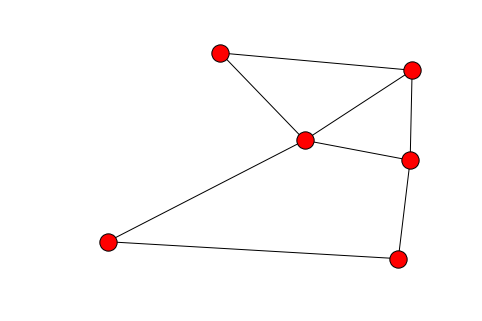

In [96]:
nx.draw(a_islands)

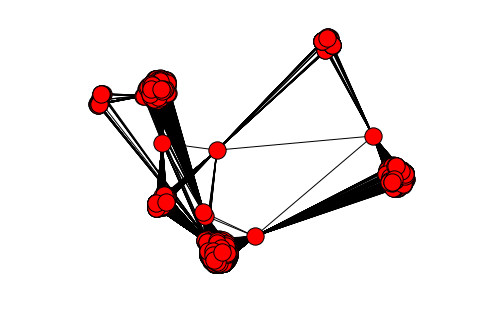

In [100]:
nx.draw(j_islands)
pos=nx.circular_layout(j_islands)